# Physics-Informed Option Pricing Models

This notebook explores option pricing models inspired by non-equilibrium
statistical mechanics. We investigate whether mean-reverting potentials
(Smoluchowski dynamics) and external fields (Onsager-like forces) can
naturally reproduce volatility smiles and implied volatility surfaces
observed in financial markets.

Models are compared against the Black–Scholes baseline and calibrated
to real equity data (NVDA).

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import newton, minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.style.use("seaborn-v0_8-darkgrid")
np.random.seed(42)

In [4]:
def black_scholes_call(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def implied_volatility(S, K, T, r, price):
    if price <= max(S - K, 0):
        return 0.0
    f = lambda sigma: black_scholes_call(S, K, T, r, sigma) - price
    try:
        return newton(f, x0=0.4, tol=1e-4, maxiter=50)
    except:
        return np.nan

In [5]:
ticker = "NVDA"
df = yf.download(ticker, period="60d", interval="30m",
                 auto_adjust=True, progress=False).dropna()

close = df["Close"].squeeze()
log_prices = np.log(close.values)
S0 = float(close.iloc[-1])

dt = 1 / (252 * 13)  # 30-minute bars
dx = np.diff(log_prices)
x_prev = log_prices[:-1]
mu = np.mean(x_prev)

kappa = -np.sum(dx * (x_prev - mu)) / (np.sum((x_prev - mu)**2) * dt)
kappa = max(kappa, 0.01)

sigma_ann = np.std(dx) * np.sqrt(252 * 13)
r = 0.05

print(f"S0 = {S0:.2f}, σ = {sigma_ann:.3f}, κ = {kappa:.3f}")

S0 = 184.90, σ = 0.415, κ = 49.260


In [6]:
def smoluchowski_force(x):
    return -kappa * (x - mu)

def onsager_force(x, field=0.3):
    return -kappa * (x - mu) + field

In [7]:
def smoluchowski_price(S0, K, T, r, sigma, force_func,
                       n_sims=3000, steps=100):
    dt_sim = T / steps
    x = np.full(n_sims, np.log(S0))

    for _ in range(steps):
        x += force_func(x) * dt_sim + sigma * np.sqrt(dt_sim) * np.random.randn(n_sims)

    payoff = np.maximum(np.exp(x) - K, 0)
    return np.mean(payoff) * np.exp(-r * T)

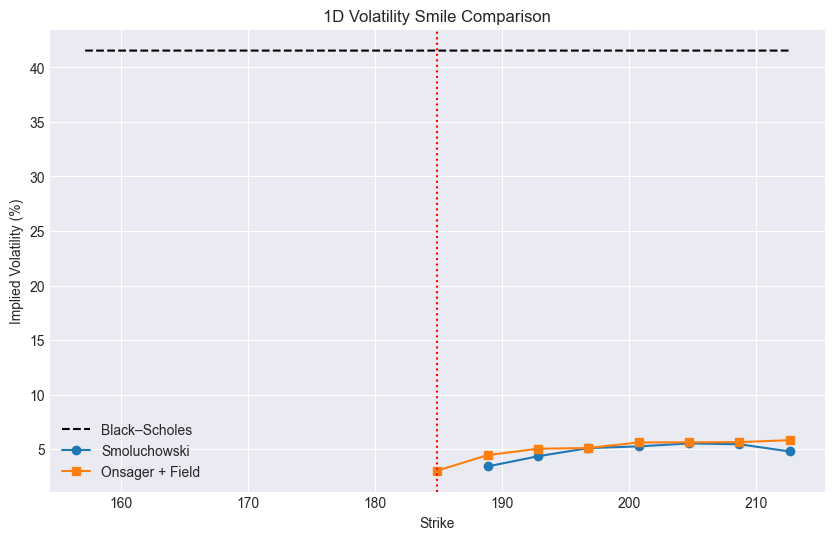

In [8]:
strikes = np.linspace(S0 * 0.85, S0 * 1.15, 15)
T_fixed = 0.5

smile_bsm, smile_smol, smile_ons = [], [], []

for K in strikes:
    p_bsm = black_scholes_call(S0, K, T_fixed, r, sigma_ann)
    smile_bsm.append(implied_volatility(S0, K, T_fixed, r, p_bsm) * 100)

    p_smol = smoluchowski_price(S0, K, T_fixed, r, sigma_ann, smoluchowski_force)
    smile_smol.append(implied_volatility(S0, K, T_fixed, r, p_smol) * 100)

    p_ons = smoluchowski_price(S0, K, T_fixed, r, sigma_ann,
                               lambda x: onsager_force(x, field=0.3))
    smile_ons.append(implied_volatility(S0, K, T_fixed, r, p_ons) * 100)

plt.figure(figsize=(10,6))
plt.plot(strikes, smile_bsm, "k--", label="Black–Scholes")
plt.plot(strikes, smile_smol, "o-", label="Smoluchowski")
plt.plot(strikes, smile_ons, "s-", label="Onsager + Field")
plt.axvline(S0, color="red", linestyle=":")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility (%)")
plt.title("1D Volatility Smile Comparison")
plt.legend()
plt.show()

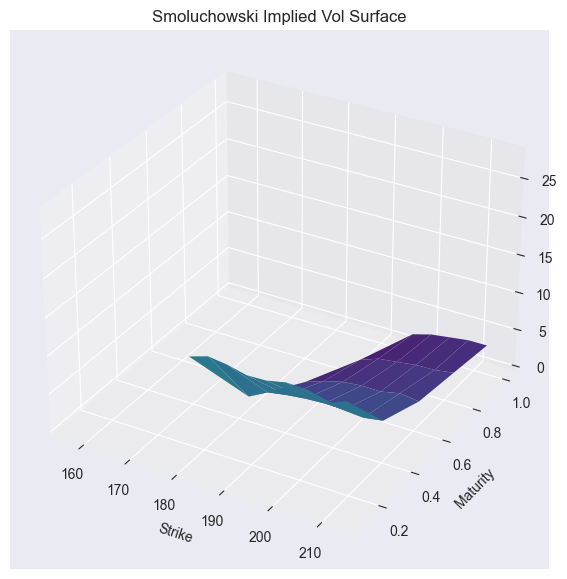

In [9]:
maturities = np.linspace(0.1, 1.0, 5)
IV_surface = np.zeros((len(maturities), len(strikes)))

for i, T in enumerate(maturities):
    for j, K in enumerate(strikes):
        price = smoluchowski_price(S0, K, T, r, sigma_ann, smoluchowski_force)
        IV_surface[i,j] = implied_volatility(S0, K, T, r, price) * 100

K_grid, T_grid = np.meshgrid(strikes, maturities)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(K_grid, T_grid, IV_surface, cmap=cm.viridis)
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_zlabel("IV (%)")
ax.set_title("Smoluchowski Implied Vol Surface")
plt.show()

SSVI calibrated parameters:
theta = nan
rho   = -0.3000
eta   = 1.0000


/var/folders/44/5bw9_dfx3f90smrnnb812k9m0000gs/T/ipykernel_55224/495764029.py:35: RuntimeWarning: Mean of empty slice
  return np.nanmean((iv_model - iv_target)**2)


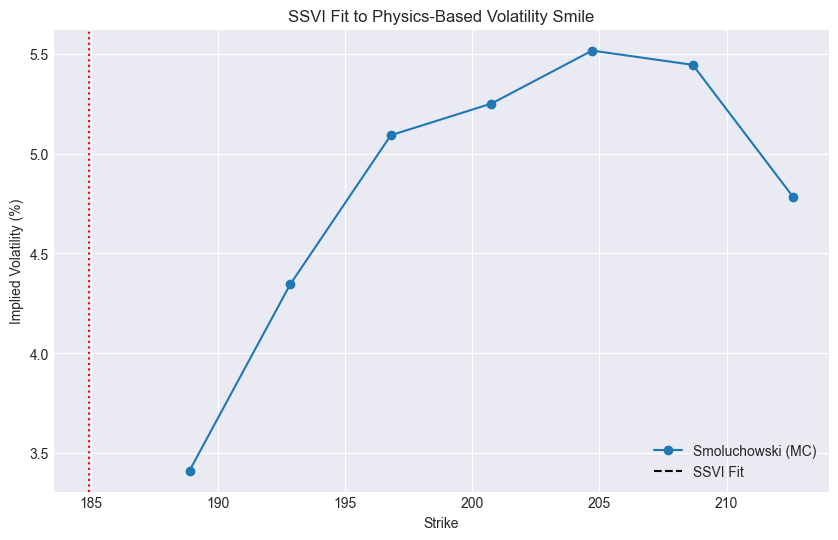

Bad pipe message: %s [b'\n\x1d\x92\x1e\x15$\xba!\x15\xdd\xf70\x99\xb2\xe0\xa2\x88\xcd\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c']
Bad pipe message: %s [b'Y\xa5\xde\xba\x0bd5\xec\x92"Rb*\x9d%\x1f\x05\xb0\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x00']
Bad pipe message: %s [b"$\xef9H\xfd\xd5\x97r'\xa5j$\xf2\xbc\xf3\xaar\x10\x00\x01|\x00\x00\x00\x01\x00\x02

In [10]:
# ---- SSVI Parameterization ----
def ssvi_total_variance(k, theta, rho, eta):
    """
    SSVI total variance w(k)
    k     : log-moneyness
    theta : ATM total variance
    rho   : correlation (-1 < rho < 1)
    eta   : curvature (> 0)
    """
    return 0.5 * theta * (
        1 + rho * eta * k +
        np.sqrt((eta * k + rho)**2 + (1 - rho**2))
    )


def ssvi_implied_vol(K, T, S0, theta, rho, eta):
    k = np.log(K / S0)
    w = ssvi_total_variance(k, theta, rho, eta)
    return np.sqrt(w / T)


# ---- Calibration Objective ----
def ssvi_loss(params, strikes, T, iv_target):
    theta, rho, eta = params

    # Enforce admissible region
    if theta <= 0 or eta <= 0 or abs(rho) >= 1:
        return 1e6

    iv_model = np.array([
        ssvi_implied_vol(K, T, S0, theta, rho, eta)
        for K in strikes
    ])

    return np.nanmean((iv_model - iv_target)**2)


# ---- Choose Maturity Slice ----
T_cal = 0.5
iv_target = np.array(smile_smol) / 100.0  # convert % → decimal

# Initial guess (robust)
theta0 = (np.mean(iv_target)**2) * T_cal
params0 = [theta0, -0.3, 1.0]

bounds = [
    (1e-4, 5.0),     # theta
    (-0.999, 0.999), # rho
    (1e-3, 10.0)     # eta
]

# ---- Optimization ----
result = minimize(
    ssvi_loss,
    params0,
    args=(strikes, T_cal, iv_target),
    bounds=bounds,
    method="L-BFGS-B"
)

theta_opt, rho_opt, eta_opt = result.x

print("SSVI calibrated parameters:")
print(f"theta = {theta_opt:.4f}")
print(f"rho   = {rho_opt:.4f}")
print(f"eta   = {eta_opt:.4f}")


# ---- Compare Smiles ----
iv_ssvi = [
    ssvi_implied_vol(K, T_cal, S0, theta_opt, rho_opt, eta_opt) * 100
    for K in strikes
]

plt.figure(figsize=(10,6))
plt.plot(strikes, smile_smol, "o-", label="Smoluchowski (MC)")
plt.plot(strikes, iv_ssvi, "k--", label="SSVI Fit")
plt.axvline(S0, color="red", linestyle=":")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility (%)")
plt.title("SSVI Fit to Physics-Based Volatility Smile")
plt.legend()
plt.show()